<a href="https://colab.research.google.com/github/ShayEK34/DPL-Assignment2/blob/main/Ass_2_Q3_Sections(a_d).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assinmgent 2, Question 3 - Corporación Favorita Grocery Sales Forecasting**

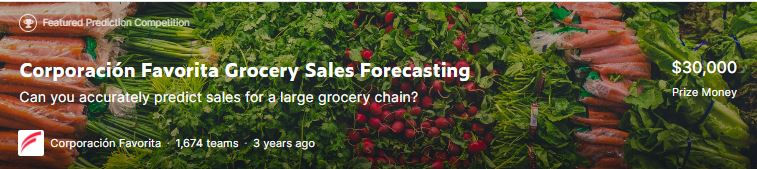

Install py7zr lib to open the zip files

# Section a - Join the Favorita Grocery Sales Forecasting competition on kaggle.com, in this competition you are requested to predict the sales for each product and customer combination for the two weeks following the end of training data(Aug 15th-31st 2017) given the sales of the preceding ~4 years. Choose a group name that starts with “BGU-DL <group-name>” format.

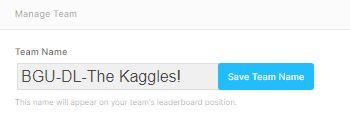

In [1]:
!pip install py7zr

Import all the libreries

In [2]:
import os
import py7zr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import gc;gc.collect
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import Input, Embedding, add, Flatten, concatenate, Dropout, Dense, BatchNormalization
from keras.models import Model
from tensorflow.keras.regularizers import l2

from tqdm import tqdm

Download the data zip files from Kaggle

In [3]:
!kaggle competitions download -c favorita-grocery-sales-forecasting

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

for f in['holidays_events.csv.7z', 'test.csv.7z', 'oil.csv.7z', 'items.csv.7z', 'transactions.csv.7z', 'sample_submission.csv.7z', 'train.csv.7z', 'stores.csv.7z']:
    zf = py7zr.SevenZipFile(os.path.join('..', 'content', f), mode='r')
    zf.extractall('../content/datasets')

Reduce memory function to reduce size of Dataframe

In [5]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of Dataframe is {:.3f} MB'.format(start_mem))

    for col in tqdm(df.columns):
        col_type = df[col].dtype

        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)

            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # elif 'datetime' not in col_type.name:
        #     df[col] = df[col].astype('datetime64[ns]')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.3f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

Normalized Weighted Root Mean Squared Logarithmic Error (NWRMSLE) metric function

In [6]:
def NWRMSLE(y, pred, w):
    return metrics.mean_squared_error(y, pred, sample_weight=w)**0.5

Get all august months data from all years

In [7]:
def get_august_years_data(df_train):
    mask1 = (df_train['date'] >= pd.to_datetime('08-01-2013')) & (df_train['date'] <= pd.to_datetime('08-31-2013'))
    df1 = df_train.loc[mask1]

    mask2 = (df_train['date'] >= pd.to_datetime('08-01-2014')) & (df_train['date'] <= pd.to_datetime('08-31-2014'))
    df2 = df_train.loc[mask2]

    mask3 = (df_train['date'] >= pd.to_datetime('08-01-2015')) & (df_train['date'] <= pd.to_datetime('08-31-2015'))
    df3 = df_train.loc[mask3]

    mask4 = (df_train['date'] >= pd.to_datetime('08-01-2016')) & (df_train['date'] <= pd.to_datetime('08-31-2016'))
    df4 = df_train.loc[mask4]

    mask5 = (df_train['date'] >= pd.to_datetime('08-01-2017')) & (df_train['date'] <= pd.to_datetime('08-31-2017'))
    df5 = df_train.loc[mask5]

    train_august_data = pd.concat([df1, df2, df3, df4, df5])
    return train_august_data

# Section b - Use a classical ML algorithm to predict the target and form a solid benchmark:

Prepare the test data dates and choose the features

In [8]:
def prepare_test_data_rfr(df_test):
    df_test['year'] = df_test["date"].dt.year
    df_test['month'] = df_test["date"].dt.month
    df_test['day'] = df_test["date"].dt.day
    processed_test_data = df_test.loc[:, ['year', 'month', 'day', 'store_nbr', 'item_nbr']].copy()
    return processed_test_data

In [9]:
path_1 = "/content/datasets/"

df_test = pd.read_csv(path_1 + 'test.csv',)
df_test = reduce_mem_usage(df_test)
print('Done Test reduce')
dtypes_dict = dict(df_test.dtypes)
df_train = pd.read_csv(path_1 + 'train.csv',dtype=dtypes_dict)
df_train = reduce_mem_usage(df_train)
df_train['date'] = pd.to_datetime(df_train.date)
df_test['date'] = pd.to_datetime(df_test.date)
print('Done Train reduce')


100%|██████████| 5/5 [00:00<00:00, 50.21it/s]

Memory usage of Dataframe is 106.073 MB
Memory usage after optimization is: 61.072 MB
Decreased by 42.4%
Done Test reduce



  0%|          | 0/6 [00:00<?, ?it/s]

Memory usage of Dataframe is 3231.449 MB


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


Memory usage after optimization is: 2752.716 MB
Decreased by 14.8%
Done Train reduce


In [10]:
selected_train_data = get_august_years_data(df_train)
selected_train_data = reduce_mem_usage(selected_train_data)

del df_train; gc.collect() 

 67%|██████▋   | 4/6 [00:00<00:00, 27.78it/s]

Memory usage of Dataframe is 302.819 MB


100%|██████████| 6/6 [00:00<00:00, 11.89it/s]


Memory usage after optimization is: 283.282 MB
Decreased by 6.5%


39

In [11]:
df_items = pd.read_csv(path_1 + 'items.csv',)
df_items = reduce_mem_usage(df_items)

df_stores = pd.read_csv(path_1 + 'stores.csv',)
df_stores = reduce_mem_usage(df_stores)

100%|██████████| 5/5 [00:00<00:00, 869.32it/s]

Memory usage of Dataframe is 0.125 MB
Memory usage after optimization is: 0.059 MB
Decreased by 53.1%
Memory usage of Dataframe is 0.002 MB
Memory usage after optimization is: 0.001 MB
Decreased by 33.0%


we did merge with item table to get the wights, reduce the data memory and make log on the target to use the metric NWRMSLE.

In [12]:
data_rfr = selected_train_data.merge(df_items, how='inner', on= 'item_nbr')
data_rfr['year'] = data_rfr["date"].dt.year
data_rfr['month'] = data_rfr["date"].dt.month
data_rfr['day'] = data_rfr["date"].dt.day
data_rfr_reduced = reduce_mem_usage(data_rfr)

target = data_rfr_reduced['unit_sales'].values
target[target < 0.] = 0.
data_rfr_reduced['unit_sales'] = np.log1p(target)

del data_rfr; gc.collect()

 33%|███▎      | 4/12 [00:00<00:00, 27.86it/s]

Memory usage of Dataframe is 625.175 MB


100%|██████████| 12/12 [00:00<00:00, 13.20it/s]


Memory usage after optimization is: 429.808 MB
Decreased by 31.2%


12

We choose the features to train the model.
Than we splitted the data for train and validation.
Train data- all august monthes from years (2013-2016)
Validation data - the first two weeks of august.
we save the wights of the items for train and validation.

In [13]:
data_rfr_selected = data_rfr_reduced.groupby(['date','year','month','day', 'store_nbr', 'item_nbr','perishable']).agg({'unit_sales': ['sum']}).reset_index()
data_rfr_selected.columns = ['date','year','month','day', 'store_nbr', 'item_nbr' ,'perishable','unit_sales_pred']
features = ['year','month','day', 'store_nbr', 'item_nbr', 'perishable']

#spilt train set
x_train = data_rfr_selected[~(data_rfr_selected['date'] >='08-31-2016')]
y_train = x_train['unit_sales_pred']
x_train= x_train[features]

#spilt validation set
x_val = data_rfr_selected[~(data_rfr_selected['date'] <='08-01-2017')]
y_val = x_val['unit_sales_pred']
x_val= x_val[features]

W_train = x_train['perishable']
W_val = x_val['perishable']

x_train = x_train.drop(['perishable'], axis = 1)
x_val = x_val.drop(['perishable'], axis=1)

We choose to use Random Forest Regressor for ML algorithm benchmark.

In [14]:
rfr_model = RandomForestRegressor(n_estimators=25, random_state=10, max_depth=15, n_jobs=-1, criterion='mse')

print("start fitting model...")
rfr_model.fit(x_train, y_train)
print("done fitting model!")

print("start predict model...")
train_pred = rfr_model.predict(x_train)
val_pred = rfr_model.predict(x_val)
print("end predict model!")

start fitting model...
done fitting model!
start predict model...
end predict model!


To evaluate the results we used the metrics MSE and NWRMSLE on the results of the train in validation.

In [15]:
print("start evaluate model:")

# Mean squared error (MSE) - Train
mse_train = mean_squared_error(y_train.values.ravel(), train_pred)
print('Mean Squared Error: - train:', round(mse_train, 2))

# Normalized Weighted Root Mean Squared Logarithmic Error (NWRMSLE) - Train
print('NWRMSLE RF Train',NWRMSLE((y_train),(train_pred),W_train.values ))

# Mean squared error (MSE) -Validation
mse_val = mean_squared_error(y_val.values.ravel(), val_pred)
print('Mean Squared Error: - val:', round(mse_val, 2))

# Normalized Weighted Root Mean Squared Logarithmic Error (NWRMSLE) - Validation
print('NWRMSLE RF Val',NWRMSLE((y_val),(val_pred),W_val.values ))

start evaluate model:
Mean Squared Error: - train: 0.55
NWRMSLE RF Train 0.7376459986560973
Mean Squared Error: - val: 0.57
NWRMSLE RF Val 0.747039748388704


we prepare the test data for submission. we create the prdicted column unit sales and we raise back in log the results. 

In [16]:
test_data = prepare_test_data_rfr(df_test)
preds_test = rfr_model.predict(test_data)
preds_test= np.expm1(preds_test)
df_test['unit_sales'] = preds_test

df_test[['id','unit_sales']].to_csv('submission_rfr.csv', index=False, float_format='%.4f')

The submission file of the Random Forest Regressor results we upload to Kaggle to get the score to use as solid benchmark on the test.

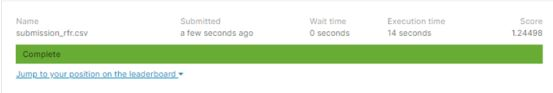

# Section c - Perform the relevant preprocessing steps to create an embedding for the store id and for the item id (you may choose to create an embedding of additional dataset features that you think are relevant).

Helper functions for preprocessing steps to create an embedding model:

This function get the train data and items data, smearge the to one df by item_nbr (we need the wights from column pershible in items). Then we splitted the date for three columns day, month, year so we can use it in our models as features and we used log on the target for use the metric NWRMSLE.

In [17]:
def mearge_items_train(data, df_items):

    data_emb_train = data.merge(df_items, how='inner', on='item_nbr')

    data_emb_train['year'] = data_emb_train["date"].dt.year
    data_emb_train['month'] = data_emb_train["date"].dt.month
    data_emb_train['day'] = data_emb_train["date"].dt.day
    data_emb_train_reduced = reduce_mem_usage(data_emb_train)
    
    target = data_emb_train_reduced['unit_sales'].values
    target[target < 0.] = 0.
    data_emb_train_reduced['unit_sales'] = np.log1p(target)

    data_emb_train_selected = data_emb_train_reduced.groupby(['date', 'year', 'month', 'day', 'store_nbr', 'item_nbr', 'perishable']).agg({'unit_sales': ['sum']}).reset_index()
    data_emb_train_selected.columns = ['date', 'year', 'month', 'day', 'store_nbr', 'item_nbr', 'perishable', 'unit_sales']
    return data_emb_train_selected

This function prepare the test data features for using the model.

In [18]:
def prepare_test_data(data):

    data['year'] = data["date"].dt.year
    data['month'] = data["date"].dt.month
    data['day'] = data["date"].dt.day
    data_test_reduced = reduce_mem_usage(data)

    return data_test_reduced

This function get the train data, items data, and stores data and create a dictionary using enumerate that maps every value in each feature to number from 0 to n-1. 

In [19]:
def enumerate_featuers(train_data_merge, df_items, df_stores):
    year = {p: i for (i, p) in enumerate(train_data_merge['year'].unique())}
    month = {p: i for (i, p) in enumerate(train_data_merge['month'].unique())}
    day = {p: i for (i, p) in enumerate(train_data_merge['day'].unique())}
    store_nbr = {p: i for (i, p) in enumerate(df_stores['store_nbr'].unique())}
    item_nbr = {p: i for (i, p) in enumerate(df_items['item_nbr'].unique())}
    enumerate_list = [year, month, day, store_nbr, item_nbr]
    return enumerate_list

This function get the train data and the enumerate lists and change the train value features by the dictioneries we created in the enumerate process.

In [20]:
def process_train_data(data_emb_selected,enumarate_list):
    processed_data = data_emb_selected.loc[:, ['year', 'month', 'day', 'store_nbr', 'item_nbr', 'perishable']].copy()

    # items categorical featuers
    year = enumarate_list[0]
    month = enumarate_list[1]
    day = enumarate_list[2]
    store_nbr = enumarate_list[3]
    item_nbr = enumarate_list[4]
    processed_data['year'] = [year[x] for x in data_emb_selected['year']]
    processed_data['month'] = [month[x] for x in data_emb_selected['month']]
    processed_data['day'] = [day[x] for x in data_emb_selected['day']]
    processed_data['store_nbr'] = [store_nbr[x] for x in data_emb_selected['store_nbr']]
    processed_data['item_nbr'] = [item_nbr[x] for x in data_emb_selected['item_nbr']]

    target = data_emb_selected['unit_sales'].values

    return processed_data, target

This function get the test data and the enumerate lists and change the test value features by the dictioneries we created in the enumerate process.

In [21]:
def process_test_data(data_emb_selected,enumarate_list):
    processed_data = data_emb_selected.loc[:, ['year', 'month', 'day', 'store_nbr', 'item_nbr']].copy()

    # items categorical featuers
    year = enumarate_list[0]
    month = enumarate_list[1]
    day = enumarate_list[2]
    store_nbr = enumarate_list[3]
    item_nbr = enumarate_list[4]
    processed_data['year'] = [year[x] for x in data_emb_selected['year']]
    processed_data['month'] = [month[x] for x in data_emb_selected['month']]
    processed_data['day'] = [day[x] for x in data_emb_selected['day']]
    processed_data['store_nbr'] = [store_nbr[x] for x in data_emb_selected['store_nbr']]
    processed_data['item_nbr'] = [item_nbr[x] for x in data_emb_selected['item_nbr']]

    return processed_data

This function create the input layes for the model features and the embedding layers. Then we create a model and we used them.

In [22]:
def build_embedding_model(enumerate_list):
    year_inp = Input(shape=(1,), dtype='int64')
    month_inp = Input(shape=(1,), dtype='int64')
    day_inp = Input(shape=(1,), dtype='int64')
    store_inp = Input(shape=(1,), dtype='int64')
    item_inp = Input(shape=(1,), dtype='int64')
    
    year_emb = Embedding(len(enumerate_list[0]), 5, input_length=1, embeddings_regularizer=l2(1e-6))(year_inp)
    month_emb = Embedding(len(enumerate_list[1]), 5, input_length=1, embeddings_regularizer=l2(1e-6))(month_inp)
    day_emb = Embedding(len(enumerate_list[2]), 5, input_length=1, embeddings_regularizer=l2(1e-6))(day_inp)
    store_emb = Embedding(len(enumerate_list[3]), 8, input_length=1, embeddings_regularizer=l2(1e-6))(store_inp)
    item_emb = Embedding(len(enumerate_list[4]), 16, input_length=1, embeddings_regularizer=l2(1e-6))(item_inp)

    x = concatenate([year_emb, month_emb, day_emb, store_emb, item_emb], name='embedding_model')
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    x = Dense(8, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(1, activation='relu')(x)
    embedding_model = Model([year_inp, month_inp, day_inp, store_inp, item_inp], x)

    embedding_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    embedding_model.summary()
    return embedding_model

In [23]:
def set_callbacks(description='run1', patience=15, tb_base_logdir='./logs/'):
    cp = ModelCheckpoint('best_model_weights_{}.h5'.format(description), save_best_only=True)
    es = EarlyStopping(patience=patience, monitor='val_loss')
    rlop = ReduceLROnPlateau(patience=5)
    cb = [cp, es, rlop]
    return cb

In [24]:
def plot_results(history):
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [25]:
train_data_merge = mearge_items_train(selected_train_data, df_items)
 
enumerate_train = enumerate_featuers(train_data_merge,df_items,df_stores)

train_features, target = process_train_data(train_data_merge,enumerate_train)

embedding_model = build_embedding_model(enumerate_train)

 33%|███▎      | 4/12 [00:00<00:00, 27.57it/s]

Memory usage of Dataframe is 625.175 MB


100%|██████████| 12/12 [00:00<00:00, 13.27it/s]


Memory usage after optimization is: 429.808 MB
Decreased by 31.2%
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
____________________________

In [26]:
x_train, x_val, y_train, y_val = train_test_split(train_features, target, test_size=0.2)

W_train = x_train['perishable'].map({0:1.0, 1:1.25})
W_val = x_val['perishable'].map({0:1.0, 1:1.25})

x_train = x_train.drop(['perishable'], axis = 1)
x_val = x_val.drop(['perishable'], axis=1)

features = ['year','month','day', 'store_nbr', 'item_nbr']

Epoch 1/30
256072/256072 [==============================] - 614s 2ms/step - loss: 0.4719 - mse: 0.4698 - val_loss: 0.4359 - val_mse: 0.4295
Epoch 2/30
256072/256072 [==============================] - 618s 2ms/step - loss: 0.3918 - mse: 0.3848 - val_loss: 0.4701 - val_mse: 0.4615
Epoch 3/30
256072/256072 [==============================] - 613s 2ms/step - loss: 0.3870 - mse: 0.3781 - val_loss: 0.4996 - val_mse: 0.4899
Epoch 4/30
256072/256072 [==============================] - 619s 2ms/step - loss: 0.3848 - mse: 0.3749 - val_loss: 0.4640 - val_mse: 0.4537
Epoch 5/30
256072/256072 [==============================] - 622s 2ms/step - loss: 0.3830 - mse: 0.3725 - val_loss: 0.4500 - val_mse: 0.4392
Epoch 6/30
256072/256072 [==============================] - 621s 2ms/step - loss: 0.3816 - mse: 0.3708 - val_loss: 0.4444 - val_mse: 0.4335
Epoch 7/30
256072/256072 [==============================] - 626s 2ms/step - loss: 0.3732 - mse: 0.3625 - val_loss: 0.4168 - val_mse: 0.4067
Epoch 8/30
256072/25

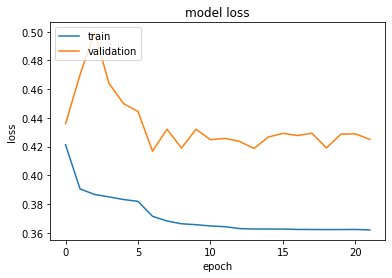

In [27]:
model_history = embedding_model.fit([x_train[f] for f in features], y_train, epochs=30,
                validation_data=([x_val[f] for f in features], y_val),callbacks=set_callbacks())

plot_results(model_history)

In [32]:
embedding_model.load_weights('./best_model_weights_run1.h5')
preds = embedding_model.predict([x_val[f] for f in features])

# Normalized Weighted Root Mean Squared Logarithmic Error (NWRMSLE) - Validation
print('NWRMSLE Embedding - Validation:', NWRMSLE((y_val), (preds), W_val.values))

NWRMSLE Embedding - Validation: 0.6398163383110098


#Section d - Try predicting the target using only the features embeddings in a DL regressor, report the metrics you received on your training, validation and test set (submission to competition).

In [29]:
test_data = prepare_test_data(df_test)
process_test_data = process_test_data(test_data,enumerate_train)

 56%|█████▌    | 5/9 [00:00<00:00, 26.46it/s]

Memory usage of Dataframe is 163.931 MB


100%|██████████| 9/9 [00:00<00:00, 29.38it/s]


Memory usage after optimization is: 80.358 MB
Decreased by 51.0%


In [30]:
preds_test = embedding_model.predict([process_test_data[f] for f in features])
preds_test= np.expm1(preds_test)
df_test['unit_sales'] = preds_test

df_test[['id','unit_sales']].to_csv('submission_emb.csv', index=False, float_format='%.4f')

The submission file of the embedding model results we upload to Kaggle to get the score to use as solid benchmark on the test.

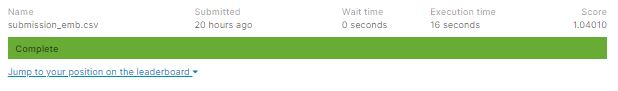